# Experimenting with Temporal Cross-Validation Using snapshot_year

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

DATA_PROCESSED = Path("../data/processed/hr_attrition_clean.csv")
df = pd.read_csv(DATA_PROCESSED)

TARGET_COL = "attrited"
DATE_COL = "snapshot_date"

date_col = DATE_COL

if date_col is None:
    raise ValueError("No snapshot date/year column found. Add 'snapshot_date' or 'snapshot_year'.")
df[date_col] = pd.to_datetime(df[date_col])
df["snapshot_year"] = df[date_col].dt.year
year_col = "snapshot_year"

years = sorted(df[year_col].unique())
print("Years in data:", years)
assert TARGET_COL in df.columns

Years in data: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


In [ ]:
drop_cols = [
    "employee_id",
    "exit_interview_scheduled",
    "offboarding_ticket_created",
    "months_since_hire",
    "salary_band",              
    year_col                    # year is for splitting, not a predictor
]

drop_vif_cols = [
    "compa_ratio",         
    "avg_raise_3y",       
    "benefit_score",       
    "manager_quality",     
    "workload_score",       
    "stock_grants",         
    "age",                 
    "internal_moves_last_2y",  
    "mgmt_workload_risk",    
    "workload_score"    
]

df_model = df.copy()

In [4]:
# --- Engineered features with no leakage ---
def add_mgmt_workload_features(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    # Binary flag (for insights). Will be dropped from X before modeling.
    df["mgmt_workload_risk"] = ((df[mq_col].isna()) | ((mq < 5) & (wl > 7))).astype(int)

    # Use a multiplicative interaction so higher workload with worse manager increases risk nonlinearly
    df["mgmt_workload_score"] = (10 - mq) * wl

    return df

df_model = add_mgmt_workload_features(df_model)

In [5]:
drop_cols = [c for c in (drop_cols + drop_vif_cols) if c in df.columns]
df_model = df_model.drop(columns=drop_cols)

In [6]:
# Split features/target
X_all = df_model.drop(columns=[TARGET_COL])
y_all = df[TARGET_COL].astype(int)

num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_all.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("Num:", len(num_cols), "Cat:", len(cat_cols))

Num: 20 Cat: 7


In [7]:
X_all.columns

Index(['snapshot_date', 'hire_date', 'region', 'department', 'role', 'level',
       'is_manager', 'gender', 'remote_status', 'commute_km', 'tenure_years',
       'base_salary', 'time_since_last_promo_yrs', 'performance_rating',
       'engagement_score', 'learning_hours_last_yr', 'overtime_hours_month',
       'night_shift', 'schedule_flex', 'sick_days', 'pto_days_taken',
       'leave_last_yr', 'team_id', 'commute_zero', 'internal_moves_flag',
       'stock_grants_flag', 'mgmt_workload_risk', 'mgmt_workload_score'],
      dtype='object')

In [8]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False))
])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1),
    threshold="median",
    prefit=False
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])

models = {"LogReg+SelectFromModel": pipe_lr, "RF+SelectFromModel": pipe_rf}

In [9]:
def eval_temporal_split(model, X, y, years_series, train_max_year, verbose=True):
    test_year = train_max_year + 1
    tr_mask = years_series <= train_max_year
    te_mask = years_series == test_year
    if te_mask.sum() == 0:
        raise ValueError(f"No rows for test year {test_year}.")

    X_tr, y_tr = X.loc[tr_mask], y.loc[tr_mask]
    X_te, y_te = X.loc[te_mask], y.loc[te_mask]

    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    auc = roc_auc_score(y_te, proba)
    ap  = average_precision_score(y_te, proba)
    if verbose:
        print(f"Train ≤ {train_max_year} → Test {test_year} | AUC={auc:.3f} | PR AUC={ap:.3f}")
        print(classification_report(y_te, pred, digits=3))

    fpr, tpr, _ = roc_curve(y_te, proba)
    prec, rec, _ = precision_recall_curve(y_te, proba)
    return {"auc": auc, "ap": ap, "fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec, "model": model, "train_year": train_max_year, "test_year": test_year}

In [10]:
target_train_year = 2022
assert target_train_year in years and (target_train_year + 1) in years, "Need 2022 & 2023 in data."

res = {}
for name, mdl in models.items():
    res[name] = eval_temporal_split(mdl, X_all, y_all, df[year_col], target_train_year, verbose=True)

Train ≤ 2022 → Test 2023 | AUC=0.652 | PR AUC=0.280
              precision    recall  f1-score   support

           0      0.830     0.990     0.903      4204
           1      0.389     0.032     0.059       882

    accuracy                          0.823      5086
   macro avg      0.609     0.511     0.481      5086
weighted avg      0.753     0.823     0.756      5086

Train ≤ 2022 → Test 2023 | AUC=0.632 | PR AUC=0.269
              precision    recall  f1-score   support

           0      0.827     1.000     0.905      4204
           1      0.000     0.000     0.000       882

    accuracy                          0.827      5086
   macro avg      0.413     0.500     0.453      5086
weighted avg      0.683     0.827     0.748      5086



/Users/stewartrobertson/opt/miniconda3/envs/hr-predictive-modelling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/stewartrobertson/opt/miniconda3/envs/hr-predictive-modelling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/stewartrobertson/opt/miniconda3/envs/hr-predictive-modelling/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

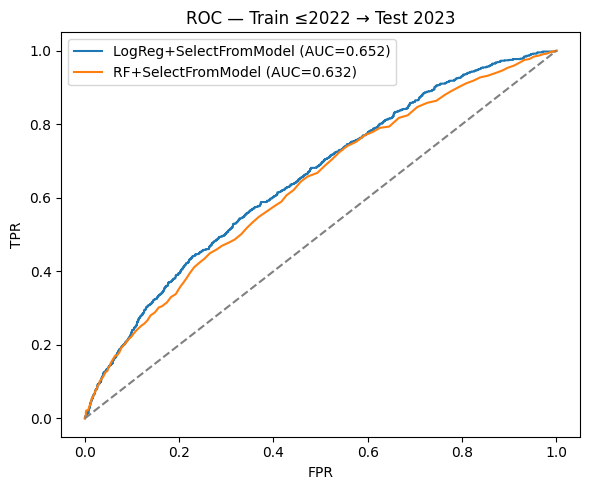

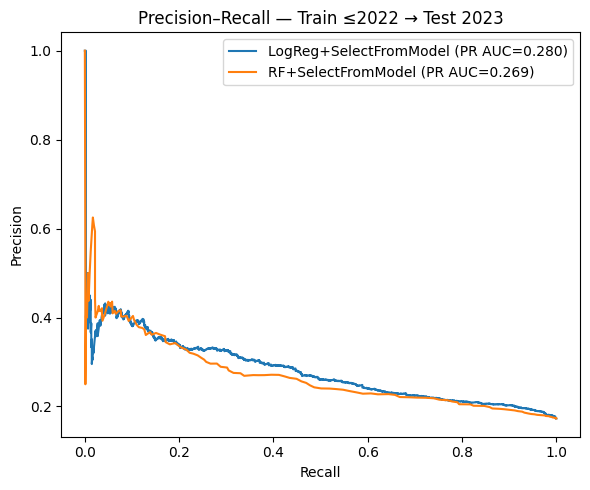

In [11]:
plt.figure(figsize=(6,5))
for name, r in res.items():
    plt.plot(r["fpr"], r["tpr"], label=f"{name} (AUC={r['auc']:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title(f"ROC — Train ≤{target_train_year} → Test {target_train_year+1}")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
plt.savefig("../reports/ROCcomparisonTimeCV.png")
plt.show()

plt.figure(figsize=(6,5))
for name, r in res.items():
    plt.plot(r["rec"], r["prec"], label=f"{name} (PR AUC={r['ap']:.3f})")
plt.title(f"Precision–Recall — Train ≤{target_train_year} → Test {target_train_year+1}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout()
plt.savefig("../reports/PrecisionRecallTimeCV.png")
plt.show()

In [12]:
def rolling_backtest(models, X, y, years_series, min_train_year=None):
    years_sorted = sorted(years_series.unique())
    if min_train_year is None:
        min_train_year = years_sorted[0] + 1  # need at least 1 train year
    summary = {name: [] for name in models}
    for y_train_max in years_sorted:
        y_test = y_train_max + 1
        if y_train_max < min_train_year or y_test not in years_sorted:
            continue
        for name, mdl in models.items():
            r = eval_temporal_split(mdl, X, y, years_series, y_train_max, verbose=False)
            summary[name].append((y_train_max, r["auc"], r["ap"]))
    return summary

bt = rolling_backtest(models, X_all, y_all, df[year_col])
for name, rows in bt.items():
    if rows:
        years_, aucs, aps = zip(*rows)
        print(name, "AUC:", np.round(np.mean(aucs),3), "±", np.round(np.std(aucs),3),
              "| PR AUC:", np.round(np.mean(aps),3), "±", np.round(np.std(aps),3))

LogReg+SelectFromModel AUC: 0.659 ± 0.005 | PR AUC: 0.275 ± 0.004
RF+SelectFromModel AUC: 0.639 ± 0.005 | PR AUC: 0.272 ± 0.002


In [13]:
best_name = max(res.keys(), key=lambda n: res[n]["auc"])
best_pipe = models[best_name]
print("Selected:", best_name)

train_mask_final = df[year_col] <= target_train_year
best_pipe.fit(X_all.loc[train_mask_final], y_all.loc[train_mask_final])

from joblib import dump
Path("../models").mkdir(parents=True, exist_ok=True)
dump(best_pipe, f"../models/attrition_model_timesplit_train_to_{target_train_year}.pkl")
print("Saved:", f"../models/attrition_model_timesplit_train_to_{target_train_year}.pkl")

Selected: LogReg+SelectFromModel
Saved: ../models/attrition_model_timesplit_train_to_2022.pkl
